# `polars playbook`: basic introduction

Mal Minhas, 18.12.21

This playbook explores [`polars`](https://pola-rs.github.io/polars-book/user-guide/introduction.html) an interesting looking, highly efficient dataframe library written in Rust with both eager and lazy evaluation support.  `polars` is not an exact analogue for `pandas` but it is close enough and also provides a mechanism for outputting a `pandas` dataframe for convenience.  This means it can be used in a workflow where `polors` is used to process and manipulate the dataframe and `pandas` is used to plot it.

## 1. Installation

Install the following Python modules into a virtualenv called polars

`$ pip install polars, jupyterlab, pandas, matplotlib, pyarrow`

## 2. Basic usage with csv file

Here we are loading the famous [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) from a URL:

In [1]:
import polars as pl

df = pl.read_csv("https://j.mp/iriscsv")

Let's check we get 150 rows of 5 columns:

In [2]:
df.shape

(150, 5)

Let's check the columns are as expected:

In [3]:
list(zip(df.columns,df.dtypes))

[('sepal_length', polars.datatypes.Float64),
 ('sepal_width', polars.datatypes.Float64),
 ('petal_length', polars.datatypes.Float64),
 ('petal_width', polars.datatypes.Float64),
 ('species', polars.datatypes.Utf8)]

Now we can create a new dataframe for all rows with `sepal_length` > 5, do a `groupby` on `species` and get both `count` and `sum` on these groups:

In [4]:
df.filter(pl.col("sepal_length") > 5).\
     groupby("species").\
     agg([pl.col('sepal_length').count(), 
          pl.col('sepal_length').sum()
     ])

species,sepal_length_count,sepal_length_sum
str,u32,f64
"""virginica""",49,324.49999999999994
"""versicolor""",47,281.9
"""setosa""",22,116.89999999999999


## 3. Lazy API

`polars` has both an **eager** and **lazy** API:

> the eager API must feel very similar to users familiar to Pandas. The lazy API is more declarative, and describes _what one wants_ instead of _how one wants it_.
> The lazy API builds a query plan. Nothing is executed until you explicitly ask Polars to execute the query (via LazyFrame.collect(), or LazyFrame.fetch()). This provides Polars with the entire context of the query, allowing optimizations and choosing the fastest algorithm given that context.

Here's how to do the previous request using the lazy API - note this requires that you download the iris.csv file locally:

In [5]:
q = (
    pl.scan_csv("iris.csv")
    .filter(pl.col("sepal_length") > 5)
    .groupby("species")
    .agg([pl.col("sepal_length").count(),
          pl.col("sepal_length").sum()
    ])
    .sort(by='species')
)
df = q.collect()
print(type(df))
df

<class 'polars.internals.frame.DataFrame'>


species,sepal_length_count,sepal_length_sum
str,u32,f64
"""setosa""",22,116.89999999999999
"""versicolor""",47,281.9
"""virginica""",49,324.49999999999994


Here we are doing a conditional apply using the lazy API:

> Modifying a Series or a column in a DataFrame consists of two steps.
> 1. Creating a boolean mask based on some predicate.
> 2. Replace the values where the mask evaluates True
> 3. (Only in lazy) Define values where the mask evaluates False

In [6]:
predicate = pl.col("sepal_length") >= 5
q = pl.scan_csv("iris.csv").with_column(pl.when(predicate).then(pl.col("sepal_length")).otherwise(0.0).alias("greater than 5"))
df = q.collect()
df.head(10)

sepal_length,sepal_width,petal_length,petal_width,species,greater than 5
f64,f64,f64,f64,str,f64
5.1,3.5,1.4,0.2,"""setosa""",5.1
4.9,3,1.4,0.2,"""setosa""",0.0
4.7,3.2,1.3,0.2,"""setosa""",0.0
4.6,3.1,1.5,0.2,"""setosa""",0.0
5,3.6,1.4,0.2,"""setosa""",5
5.4,3.9,1.7,0.4,"""setosa""",5.4
4.6,3.4,1.4,0.3,"""setosa""",0.0
5,3.4,1.5,0.2,"""setosa""",5
4.4,2.9,1.4,0.2,"""setosa""",0.0


## 4. More filter and groupby

Let's create a new `polars` dataframe:

In [7]:
df = pl.DataFrame(
    {
        "A": [1, 2, 3, 4, 5],
        "fruits": ["banana", "banana", "apple", "apple", "banana"],
        "B": [5, 4, 3, 2, 1],
        "cars": ["beetle", "audi", "beetle", "beetle", "beetle"],
        "optional": [28, 300, None, 2, -30],
    }
)
df

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
3,"""apple""",3,"""beetle""",null
4,"""apple""",2,"""beetle""",2
5,"""banana""",1,"""beetle""",-30


Filter by a predicate with a regex in it:

In [8]:
predicate = pl.col("fruits").str.contains("^b.*")
df.filter(predicate)

A,fruits,B,cars,optional
i64,str,i64,str,i64
1,"""banana""",5,"""beetle""",28
2,"""banana""",4,"""audi""",300
5,"""banana""",1,"""beetle""",-30


Now lets do an eager aggregation on a groupby on `fruits`.  Note how we can retreive the `cars` list in the aggregation:

In [9]:
df.sort("cars").groupby("fruits")\
    .agg([
        pl.col("B").sum(),
        pl.first("fruits"),
        pl.count("A").alias("count"),
        pl.col("cars").reverse()
    ])

fruits,B_sum,fruits_first,count,cars
str,i64,str,u32,list
"""banana""",10,"""banana""",3,"[""beetle"", ""beetle"", ""audi""]"
"""apple""",5,"""apple""",2,"[""beetle"", ""beetle""]"


How to pull down a column as a list:

In [10]:
df["fruits"].to_list()

['banana', 'banana', 'apple', 'apple', 'banana']

How to pull out a row as a dict:

In [11]:
df[1].to_dicts()

[{'A': 2, 'fruits': 'banana', 'B': 4, 'cars': 'audi', 'optional': 300}]

How to pull out a row as a list of values:

In [12]:
df[1].transpose().to_series().to_list()

['2', 'banana', '4', 'audi', '300']

How to create a new column using eager API by applying a function to a column:

In [13]:
df = df.with_column(df["A"].apply(lambda x: x*x).alias("double A"))
df

A,fruits,B,cars,optional,double A
i64,str,i64,str,i64,i64
1,"""banana""",5,"""beetle""",28,1
2,"""banana""",4,"""audi""",300,4
3,"""apple""",3,"""beetle""",null,9
4,"""apple""",2,"""beetle""",2,16
5,"""banana""",1,"""beetle""",-30,25


Creating a new column using eager API by applying multiple functions to different columns:

In [14]:
df = df.with_columns([df["A"].apply(lambda x: x*x).alias("double A"),
                      df["B"].apply(lambda x: x*x*x).alias("cube B"),
                     ])
df

A,fruits,B,cars,optional,double A,cube B
i64,str,i64,str,i64,i64,i64
1,"""banana""",5,"""beetle""",28,1,125
2,"""banana""",4,"""audi""",300,4,64
3,"""apple""",3,"""beetle""",null,9,27
4,"""apple""",2,"""beetle""",2,16,8
5,"""banana""",1,"""beetle""",-30,25,1


## 5. Convert to `pandas` data frame for plotting

You can easily convert a `polars` dataframe to a `pandas` one as follows:

In [15]:
df = pl.read_csv("https://j.mp/iriscsv")
pdf = df.to_pandas()
print(f"Converting {type(df)} to {type(pdf)}")

Converting <class 'polars.internals.frame.DataFrame'> to <class 'pandas.core.frame.DataFrame'>


In [16]:
pdf.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


Once you have a `pandas` dataframe you can use `.plot` to draw a graph in a one liner as follows:

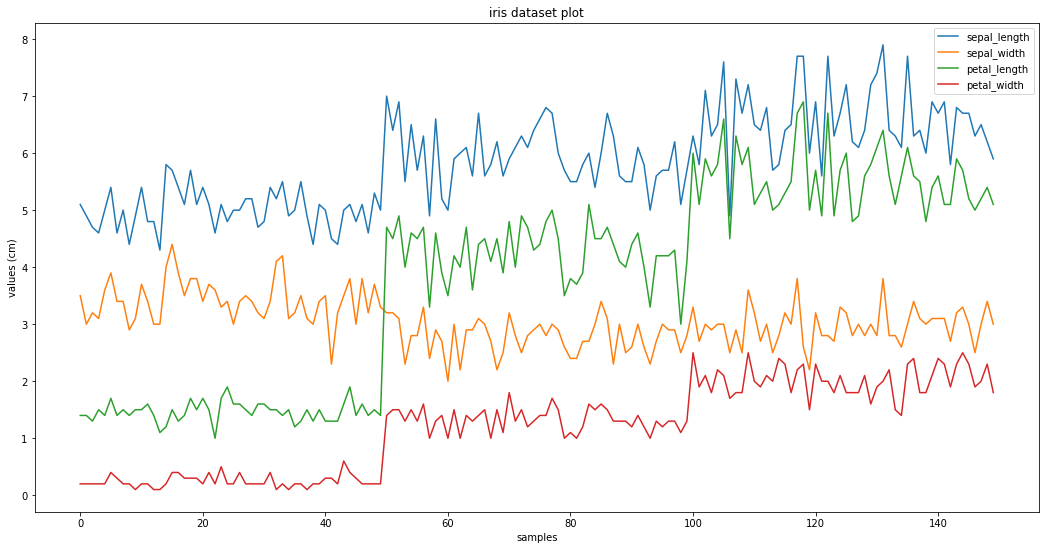

In [17]:
_ = pdf.plot(figsize=(18,9)).set(xlabel='samples', ylabel='values (cm)', title=f"iris dataset plot")

## 6. Working with timestamps

In [18]:
df = pl.read_csv('ETH_1h.csv')
df.head()

Date,Symbol,Open,High,Low,Close,Volume
str,str,f64,f64,f64,f64,f64
"""2020-03-13 08-PM""","""ETHUSD""",129.94,131.82,126.87,128.71,1.94067393e6
"""2020-03-13 07-PM""","""ETHUSD""",119.51,132.02,117.1,129.94,7.57974109e6
"""2020-03-13 06-PM""","""ETHUSD""",124.47,124.85,115.5,119.51,4.89873581e6
"""2020-03-13 05-PM""","""ETHUSD""",124.08,127.42,121.63,124.47,2.75345092e6
"""2020-03-13 04-PM""","""ETHUSD""",124.85,129.51,120.17,124.08,4.46142471e6


If we try to convert using `pl.Datetime` it doesn't appear to work:

In [19]:
df.with_column(pl.col("Date").str.strptime(pl.Datetime, fmt="%Y-%m-%d %I-%p")).head()

Date,Symbol,Open,High,Low,Close,Volume
datetime,str,f64,f64,f64,f64,f64
null,"""ETHUSD""",129.94,131.82,126.87,128.71,1.94067393e6
null,"""ETHUSD""",119.51,132.02,117.1,129.94,7.57974109e6
null,"""ETHUSD""",124.47,124.85,115.5,119.51,4.89873581e6
null,"""ETHUSD""",124.08,127.42,121.63,124.47,2.75345092e6
null,"""ETHUSD""",124.85,129.51,120.17,124.08,4.46142471e6


If we try to convert using `pl.Date` it does work but we only get the date:

In [20]:
df.with_column(pl.col("Date").str.strptime(pl.Date, fmt="%Y-%m-%d %I-%p")).head()

Date,Symbol,Open,High,Low,Close,Volume
date,str,f64,f64,f64,f64,f64
2020-03-13,"""ETHUSD""",129.94,131.82,126.87,128.71,1.94067393e6
2020-03-13,"""ETHUSD""",119.51,132.02,117.1,129.94,7.57974109e6
2020-03-13,"""ETHUSD""",124.47,124.85,115.5,119.51,4.89873581e6
2020-03-13,"""ETHUSD""",124.08,127.42,121.63,124.47,2.75345092e6
2020-03-13,"""ETHUSD""",124.85,129.51,120.17,124.08,4.46142471e6
